In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from postgres import connection
import psycopg2
from datetime import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

2023-09-08 18:12:33.257212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 18:12:34.025307: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def download_data(connection: psycopg2.extensions.connection, start_date = "2009-12-01", end_date = "2022-12-30") -> pd.DataFrame:
    cursor = connection.cursor()
    cursor.execute("SELECT ticker FROM equities")
    tickers = cursor.fetchall()
    stock_data = {}
    null_volumes = {}

    for stock_tuple in tickers:
        stock = stock_tuple[0]
        if stock == "^STI":
            continue
        table_name = f"stock_{stock[:3]}"  # Remove the .SI suffix
        query = (
            f"SELECT * FROM {table_name} WHERE Date >= %s AND Date <= %s ORDER BY Date ASC"
        )
        cursor.execute(query, (start_date, end_date))
        data = cursor.fetchall()
        if data:
            dates, open_price, high, low, close, adj_close, volume = zip(*data)
            
            if datetime.strptime(start_date, "%Y-%m-%d") != datetime.strptime(dates[0], "%Y-%m-%d") \
                or datetime.strptime(end_date, "%Y-%m-%d") != datetime.strptime(dates[-1], "%Y-%m-%d"):
                continue

            df = pd.DataFrame({
                'Date': pd.to_datetime(dates),
                'Open': open_price,
                'High': high,
                'Low': low,
                'Close': close,
                'Adj_Close': adj_close,
                'Volume': volume
            })
            if df[-1:]['Adj_Close'].values[0] < 0.2:
                continue
            # Handle special case where all columns are equal
            mask = (df['Open'] == df['High']) & (df['High'] == df['Low']) & (df['Low'] == df['Close']) & (df['Close'] == df['Adj_Close'])
            df.loc[mask, 'Volume'] = -1.0
            
            df.replace(0, np.nan, inplace=True)
            
            null_counts = df.isnull().sum()
            if null_counts.any():
                null_volumes[stock] = {'null_count': null_counts['Volume'], '0_vol': df[df['Volume'] == -1.0].shape[0]}  
            stock_data[stock] = df

    cursor.close()
    return stock_data, null_volumes


In [3]:
all_data,null_volumes = download_data(connection)

In [4]:
null_volumes_df = pd.DataFrame.from_dict(null_volumes, orient='index', columns=[ 'null_count', '0_vol'])
null_volumes_df.sort_values(by=['null_count'], ascending=False, inplace=True)
#null_volumes_df.to_excel('null_volumes.xlsx')

In [5]:
test_data = {}
training_data = {}
for stock, df in all_data.items():
    if stock in null_volumes:
        test_data[stock] = df
    else:
        training_data[stock] = df
        
print(f"Number of stocks in training data: {len(training_data)}")
print(f"Number of stocks in test data: {len(test_data)}")

Number of stocks in training data: 0
Number of stocks in test data: 97


In [6]:
for key, value in training_data.items():
    print(key)
    print(value[value['Volume'] == -1])

In [7]:
connection.close()

In [8]:
@tf.autograph.experimental.do_not_convert
def wrangle_data(sequence, data_split, examples, batch_size):
    
    # Add extra data point for labels
    examples += 1
    
    # Add a rank for the data points
    # Current: Rank 1 with 100 data points -> Rank 2 with 100 examples of 1 data point
    print('Sequence shape: ', np.shape(sequence))
    seq_expand = tf.expand_dims(sequence, -1)
    print('Sequence shape: ', np.shape(seq_expand))

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices(seq_expand)
    # Window and shift the data
    dataset = dataset.window(examples, shift=1, drop_remainder=True)
    # Convert from dataset of datasets to dataset of tensors
    dataset = dataset.flat_map(lambda x: x.batch(examples))
    
    dataset = dataset.map(lambda x: (x[:-1], x[-1]))
    
    if data_split == 'train':
        dataset = dataset.shuffle(1000)
    else:
        dataset = dataset.cache()
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


In [9]:
def compile_model(new_model, loss='mean_squared_error'):
    #adam = tf.keras.optimizers.Adam(learning_rate=0.02)
    new_model.compile(optimizer='adam', loss=loss, metrics=['mean_absolute_error'])
    print(new_model.summary())
    return new_model

In [10]:
def stacked_rnn_model_multi(features):
    new_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((None, len(features))),
        tf.keras.layers.Conv1D(30, kernel_size=6, padding='causal', activation='relu'),
        tf.keras.layers.LSTM(60, return_sequences=True),
        tf.keras.layers.LSTM(60),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    return compile_model(new_model)

In [11]:
def plot_history(history, metrics=None):

    if isinstance(metrics, str):
        metrics = [metrics]
    if metrics is None:
        metrics = [x for x in history.history.keys() if x[:4] != 'val_']
    if len(metrics) == 0:
        print('No metrics to plot')
        return
    
    x = history.epoch
    
    rows = 1
    cols = len(metrics)
    count = 0
    
    plt.figure(figsize=(12* cols, 8))
    
    for metric in sorted(metrics):
        count+=1
        plt.subplot(rows, cols, count)
        plt.plot(x, history.history[metric], label='Train')
        val_metric = f'val_{metric}'
        if val_metric in history.history.keys():
            plt.plot(x, history.history[val_metric], label='Validation')
        plt.title(metric.capitalize())
        plt.legend()
        
    plt.show()

In [24]:
def plot_sequence(time, sequences, start=0, end=None):
    y_max = 1.0
    
    if len(np.shape(sequences)) == 1:
        print('Initial Shape', np.shape(sequences))
        sequences = [sequences]
        print('Shape: ', np.shape(sequences))
    
    time = time[start:end]
    plt.figure(figsize=(12, 8))
    
    for sequence in sequences:
        print('Sequence shape: ', np.shape(sequence))
        y_max = max(y_max, np.max(sequence))
        sequence = sequence[start:end]
        plt.plot(time, sequence)
        
    plt.ylim(-2, y_max)
    plt.xlim(time[start], time[-1])
    plt.show()

In [25]:
def show_predictions(trained_model, predict_sequence, true_values, predict_time, begin=0, end=None):
    predictions = trained_model.predict(predict_sequence)
    print(predictions.shape)
    predictions = predictions[:,-1].reshape(len(predictions))
    print(predictions.shape)
    plot_sequence(predict_time, (true_values, predictions), begin, end)
    return predictions

In [26]:
def split_data(data, time, split_size):
    d_split = int(np.ceil(len(data) * split_size))
    
    big_data = data[:d_split]
    big_time = time[:d_split]
    small_data = data[d_split:]
    small_time = time[d_split:]
    
    return big_data, big_time, small_data, small_time

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, None, 30)          930       
                                                                 
 lstm_20 (LSTM)              (None, None, 60)          21840     
                                                                 
 lstm_21 (LSTM)              (None, 60)                29040     
                                                                 
 dense_30 (Dense)            (None, 32)                1952      
                                                                 
 dense_31 (Dense)            (None, 16)                528       
                                                                 
 dense_32 (Dense)            (None, 1)                 17        
                                                                 
Total params: 54307 (212.14 KB)
Trainable params: 543

2023-09-08 18:35:28.000332: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15028059919902906584
2023-09-08 18:35:28.000399: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3940035932547593476


7164/7164 [==============================] - 115s 16ms/step - loss: 0.0052 - mean_absolute_error: 0.0226 - val_loss: 0.0015 - val_mean_absolute_error: 0.0238
Epoch 2/100
   1/7164 [..............................] - ETA: 18:31 - loss: 3.6912e-05 - mean_absolute_error: 0.0055

2023-09-08 18:35:34.071475: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3940035932547593476


7164/7164 [==============================] - 110s 15ms/step - loss: 0.0045 - mean_absolute_error: 0.0199 - val_loss: 0.0016 - val_mean_absolute_error: 0.0238
Epoch 3/100
7164/7164 [==============================] - 107s 15ms/step - loss: 0.0044 - mean_absolute_error: 0.0195 - val_loss: 0.0014 - val_mean_absolute_error: 0.0241
Epoch 4/100
7164/7164 [==============================] - 109s 15ms/step - loss: 0.0045 - mean_absolute_error: 0.0196 - val_loss: 0.0015 - val_mean_absolute_error: 0.0236
Epoch 5/100
7164/7164 [==============================] - 112s 16ms/step - loss: 0.0042 - mean_absolute_error: 0.0191 - val_loss: 0.0014 - val_mean_absolute_error: 0.0224
Epoch 6/100
7164/7164 [==============================] - 113s 16ms/step - loss: 0.0042 - mean_absolute_error: 0.0191 - val_loss: 0.0014 - val_mean_absolute_error: 0.0235
Epoch 7/100
7164/7164 [==============================] - 110s 15ms/step - loss: 0.0042 - mean_absolute_error: 0.0190 - val_loss: 0.0015 - val_mean_absolute_error:

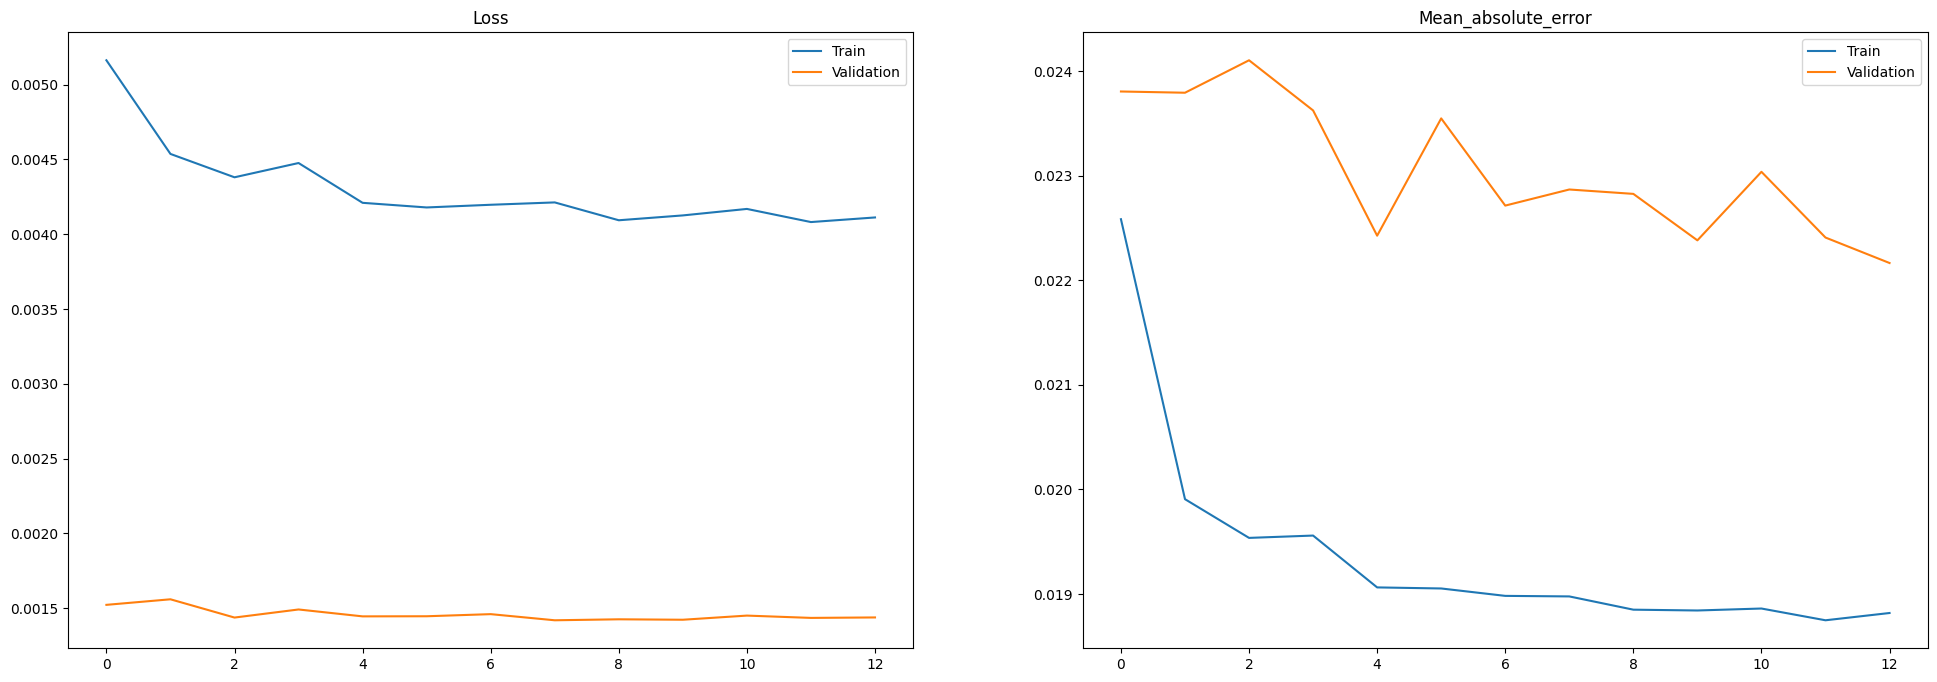

1990/1990 [==============================] - 15s 7ms/step - loss: 0.0022 - mean_absolute_error: 0.0187


2023-09-08 18:57:50.420508: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3940035932547593476


1990/1990 [==============================] - 11s 5ms/step
(63660, 1)
(63660,)
Sequence shape:  (63660,)
Sequence shape:  (63660,)


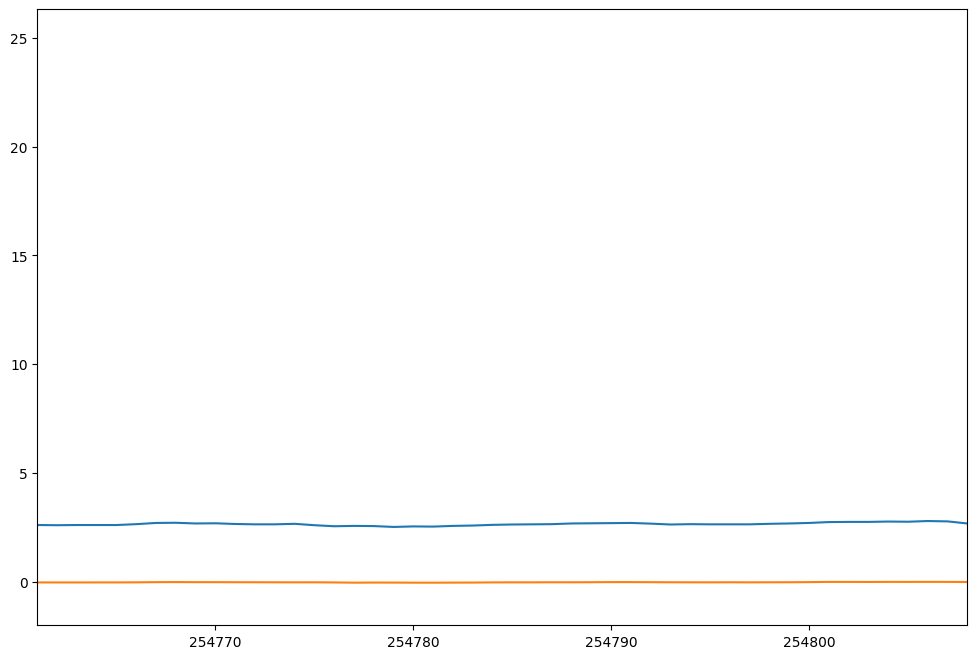

array([-0.03019643, -0.03141229, -0.03177299, ..., -0.26999107,
       -0.26907602, -0.2709763 ], dtype=float32)

In [28]:
features = ['Open', 'High', 'Low', 'Close',  'Adj_Close']
model = stacked_rnn_model_multi(features)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
all_data_concat = pd.concat(all_data.values())
data_to_predict = np.array(all_data_concat[features])
length = len(data_to_predict)
time_steps = np.array(range(length))
month = 21

scaler = StandardScaler()
rescaler = StandardScaler()
#scaler = MinMaxScaler(feature_range=(0, 1))
data_to_predict_normalizer = scaler.fit_transform(data_to_predict)
adj_close = rescaler.fit_transform(data_to_predict[:,4].reshape(-1, 1))
train_adj_close, train_time_steps, test_adj_close, test_time_steps = split_data(data_to_predict_normalizer, time_steps, 0.8)
train_adj_close, train_time_steps, val_adj_close, val_time_steps = split_data(train_adj_close, train_time_steps, 0.9)

train_data = wrangle_data(train_adj_close, 'train', month, 32)
val_data = wrangle_data(val_adj_close, 'val', month, 32)
test_data = wrangle_data(test_adj_close, 'test', month, 32)

with tf.device("/GPU:0"):
    history = model.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stop], use_multiprocessing=True, workers=12)
plot_history(history)
model.evaluate(test_data)

# Adjust prediction and plotting to handle multiple features
predictions = model.predict(test_data)
predictions = predictions[:,-1].reshape(-1, 1)
predictions = rescaler.inverse_transform(predictions)
test_volume_true = test_adj_close[month:,][:,0].reshape(-1, 1)
test_volume_true = rescaler.inverse_transform(test_volume_true) 
predictions = predictions.reshape(-1)
test_volume_true = test_volume_true.reshape(-1)
show_predictions(model, test_data, test_volume_true, test_time_steps[month:], end=2*month)